# ada-SGD algorithms
*In this lab, you will explore Adagrad, Adadelta, and Adam optimizers.

*For each task, you are provided with a code skeleton that you need to complete to implement and investigate the respective optimization algorithm.

# Task 1: Implement Adagrad
In this task, you will implement the Adagrad optimizer from scratch as a Python class, and call it to minimize the loss of classification by any simple NN and dataset, "recommended to have small NN and simple dataset to accelerate the running"


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

In [ ]:
# Task: Implement the Adadelta optimizer from scratch
class AdadeltaOptimizer:
    def __init__(self, params, rho=0.9, eps=1e-6):
        self.params = list(params)
        self.rho = rho
        self.eps = eps
        self.acc_grad = {}
        self.acc_delta = {}

        for param in self.params:
            self.acc_grad[param] = torch.zeros_like(param.data)
            self.acc_delta[param] = torch.zeros_like(param.data)

    def step(self):
        for param in self.params:
            grad = param.grad
            if grad is None:
                continue

            self.acc_grad[param] = self.rho * self.acc_grad[param] + (1 - self.rho) * grad ** 2
            delta = torch.sqrt(self.acc_delta[param] + self.eps) / torch.sqrt(self.acc_grad[param] + self.eps) * grad
            param.data -= delta
            self.acc_delta[param] = self.rho * self.acc_delta[param] + (1 - self.rho) * delta ** 2

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()



In [ ]:
# Define a simple neural network

class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(2, 1)

    def forward(self, x):
        return self.fc(x)

model = SimpleModel()
criterion = nn.MSELoss()
optimizer = AdadeltaOptimizer(model.parameters())


In [ ]:
# Dummy data
inputs = torch.randn(10, 2)
labels = torch.randn(10, 1)

num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item()}")


Epoch 1: Loss = 2.022876262664795


# Task 2: Implement Adadelta

In this task instead of adagrad which uses all the past gradient to estimate the variance of the gradients, small window of past gradient are used only. However, instead of using the squared gradient, we encourage you to propose another idea to have adaptive step size propotional to the curvature (inversly), remember the main idea of adagrad and adadelta is to update the model weights differently (adaptively) along every dimension based on the curvature of the loss.

In [ ]:
# Task: Implement the Adadelta optimizer from scratch with new G
class AdadeltaOptimizer:
    def __init__(self, params, rho=0.9, eps=1e-6):
        self.params = list(params)
        self.rho = rho
        self.eps = eps
        self.state = {}

        for param in self.params:
            self.state[param] = {'square_avg': torch.zeros_like(param.data),
                                 'acc_delta': torch.zeros_like(param.data)}

    def step(self):
        for param in self.params:
            grad = param.grad
            if grad is None:
                continue

            state = self.state[param]
            square_avg, acc_delta = state['square_avg'], state['acc_delta']

            square_avg.mul_(self.rho).addcmul_(1 - self.rho, grad, grad)
            std = square_avg.add(self.eps).sqrt_()
            delta = acc_delta.add(self.eps).sqrt_().div_(std).mul_(grad)

            param.data.add_(-delta)
            acc_delta.mul_(self.rho).addcmul_(1 - self.rho, delta, delta)

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

# Example usage:
# Create a simple model and loss function for demonstration
class SimpleModel(torch.nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = torch.nn.Linear(2, 1)

    def forward(self, x):
        return self.fc(x)

model = SimpleModel()
criterion = torch.nn.MSELoss()
optimizer = AdadeltaOptimizer(model.parameters())

# Dummy data
inputs = torch.randn(10, 2)
labels = torch.randn(10, 1)

num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    print(f"Epoch {epoch+1}: Loss = {loss.item()}")





Epoch 1: Loss = 1.0934057235717773


# Task 3: Implement Adam

Compare the ||momentum vector - full gradient || with || stochastic gradient - full gradient|| . And then change the norm to weighted Euclidean norm with weight from Adam (scaling vector)

In [111]:

class AdamOptimizer:
    def __init__(self, params, lr=0.001, beta1=0.9, beta2=0.999, epsilon=1e-8):
        self.params = list(params)
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon
        self.t = 0
        self.momentums = {}
        self.adam_avgs = {}

        for param in self.params:
            self.momentums[param] = torch.zeros_like(param.data)
            self.adam_avgs[param] = torch.zeros_like(param.data)

    def step(self, gradient):
        self.t += 1
        for param in self.params:
            if gradient[param] is None:
                continue

            grad = gradient[param]
            self.momentums[param] = self.beta1 * self.momentums[param] + (1 - self.beta1) * grad
            self.adam_avgs[param] = self.beta2 * self.adam_avgs[param] + (1 - self.beta2) * grad**2

            # Bias correction
            momentums_hat = self.momentums[param] / (1 - self.beta1**self.t)
            adam_avgs_hat = self.adam_avgs[param] / (1 - self.beta2**self.t)

            param.data -= (self.lr / (adam_avgs_hat.sqrt() + self.epsilon)) * momentums_hat

    def zero_grad(self):
        for param in self.params:
            if param.grad is not None:
                param.grad.detach_()
                param.grad.zero_()

# Helper function to compute the weighted Euclidean norm
def weighted_euclidean_norm(params, scaling_vector):
    squared_norms = []
    for param in params:
        scaled_param = scaling_vector[param] * param
        squared_norm = (scaled_param**2).sum()
        squared_norms.append(squared_norm)
    return sum(squared_norms).sqrt()

# Example usage:
# Create a simple model and loss function for demonstration
class SimpleModel(torch.nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = torch.nn.Linear(2, 1)

    def forward(self, x):
        return self.fc(x)

model = SimpleModel()
criterion = torch.nn.MSELoss()
optimizer = AdamOptimizer(model.parameters())

# Dummy data
inputs = torch.randn(10, 2)
labels = torch.randn(10, 1)

# Calculate full gradient
optimizer.zero_grad()
outputs = model(inputs)
loss = criterion(outputs, labels)
loss.backward()
full_gradient = {param: param.grad.clone() for param in model.parameters()}

# Initialize vectors to store differences
momentum_diff_norms = []
sgd_diff_norms = []
weighted_norms = []

num_epochs = 1

# Training loop
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()

    # Calculate gradient
    gradient = {param: param.grad for param in model.parameters()}

    # Update the model using Adam
    optimizer.step(gradient)

    # Calculate and store the differences
    momentum_diff_norm = weighted_euclidean_norm(model.parameters(), optimizer.momentums)
    sgd_diff_norm = weighted_euclidean_norm(model.parameters(), gradient)
    weighted_norm = weighted_euclidean_norm(model.parameters(), optimizer.adam_avgs)

    momentum_diff_norms.append(momentum_diff_norm)
    sgd_diff_norms.append(sgd_diff_norm)
    weighted_norms.append(weighted_norm)

    print(f"Epoch {epoch+1}: Loss = {loss.item()}, Momentum Diff Norm = {momentum_diff_norm}, SGD Diff Norm = {sgd_diff_norm}, Weighted Norm = {weighted_norm}")



Epoch 1: Loss = 2.691481590270996, Momentum Diff Norm = 0.1338711827993393, SGD Diff Norm = 1.3387117385864258, Weighted Norm = 0.002413479145616293


# Task4: Investigating Optimization accuracy and complexity
* compare and plot the learning curves (testing-training loss vs. time) for all three optimizers to observe the differences.
* Show how the distribution of weights change over different layers, by a histogram


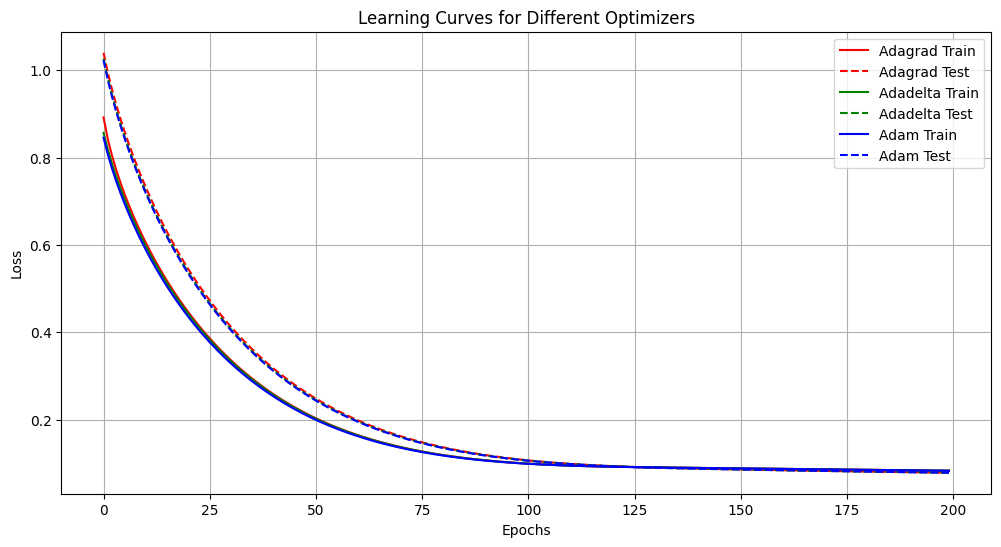

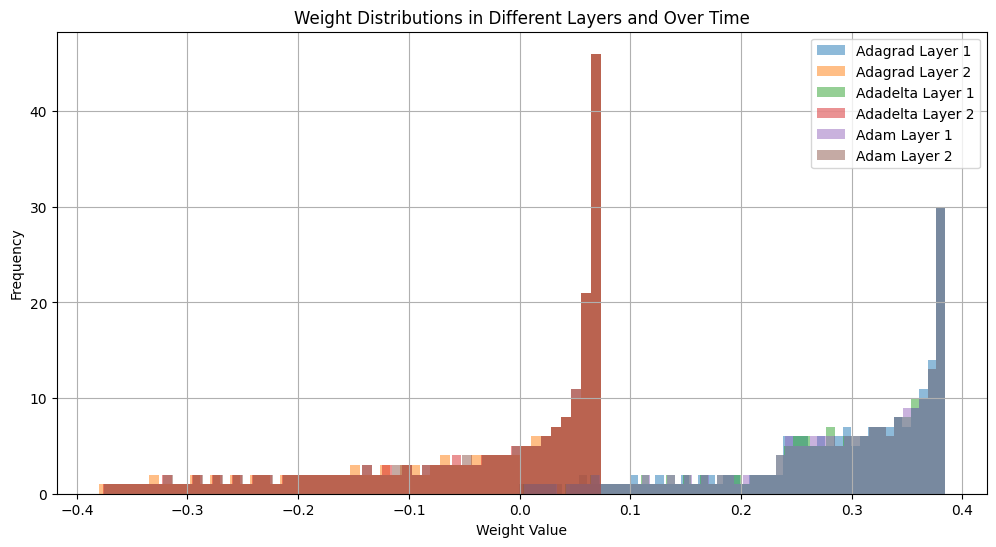

In [128]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define SimpleModel, criterion, and dataset (dummy data)
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc = nn.Linear(2, 1)

    def forward(self, x):
        return self.fc(x)

model = SimpleModel()
criterion = nn.MSELoss()

# Dummy dataset
X_train = torch.rand((100, 2))
y_train = torch.rand((100, 1))

X_test = torch.rand((20, 2))
y_test = torch.rand((20, 1))

# Define the optimizers
adagrad_optimizer = optim.Adagrad(model.parameters(), lr=0.01)
adadelta_optimizer = optim.Adadelta(model.parameters(), lr=1.0)
adam_optimizer = optim.Adam(model.parameters(), lr=0.001)

optimizers = [adagrad_optimizer, adadelta_optimizer, adam_optimizer]
optimizer_names = ["Adagrad", "Adadelta", "Adam"]
colors = ['r', 'g', 'b']

# Training and recording learning curves
num_epochs = 200
train_losses = [[] for _ in range(len(optimizers))]
test_losses = [[] for _ in range(len(optimizers))]

# Weight histories for histograms
weight_histories = {name: [] for name in optimizer_names}

for epoch in range(num_epochs):
    for i, (optimizer, name) in enumerate(zip(optimizers, optimizer_names)):
        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        # Record training loss
        train_losses[i].append(loss.item())

        # Calculate and record testing loss
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_losses[i].append(test_loss.item())

        # Record weight values for histograms
        for idx, param in enumerate(model.parameters()):
            if idx == 0:  # Weight parameters
                weight_histories[name].append(param.data.cpu().numpy().flatten())

# Plot learning curves
plt.figure(figsize=(12, 6))
for i in range(len(optimizers)):
    plt.plot(range(num_epochs), train_losses[i], label=f"{optimizer_names[i]} Train", color=colors[i])
    plt.plot(range(num_epochs), test_losses[i], label=f"{optimizer_names[i]} Test", linestyle='dashed', color=colors[i])

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Learning Curves for Different Optimizers')
plt.legend()
plt.grid(True)

# Visualize weight distributions over time
plt.figure(figsize=(12, 6))
for name in optimizer_names:
    for i, weights in enumerate(np.array(weight_histories[name]).T):
        plt.hist(weights, bins=50, alpha=0.5, label=f"{name} Layer {i + 1}")

plt.xlabel('Weight Value')
plt.ylabel('Frequency')
plt.title('Weight Distributions in Different Layers and Over Time')
plt.legend()
plt.grid(True)

plt.show()
